
Optimal Objective Function: 2575

Optimal path:
0 -> 4
1 -> 2
2 -> 3
3 -> 6
4 -> 5
5 -> 1
6 -> 0


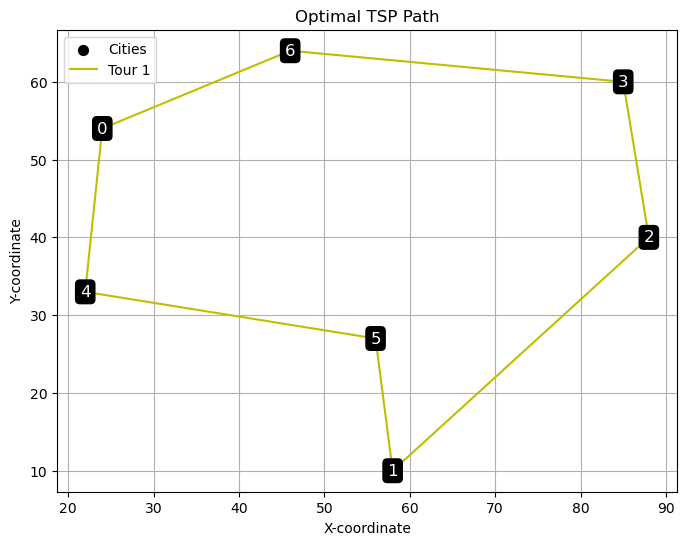

In [23]:
from gurobipy import *
import matplotlib.pyplot as plt
from gurobipy import *

# # The original distances from the Xpress example are given in DIST, and the node positions in POS
# # note that we could have different distances, for example if using the positions directly
# # also, kepp in mind that the distances in general don't have to be symmetric!

POS= [[24, 54], [58, 10], [88, 40], [85, 60], [22, 33], [56, 27], [46, 64]]

DIST= [[0, 786, 549, 657, 331, 559, 250],
       [786, 0, 668, 979, 593, 224, 905],
       [549, 668, 0, 316, 607, 472, 467],
       [657, 979, 316, 0, 890, 769, 400],
       [331, 593, 607, 890, 0, 386, 559],
       [559, 224, 472, 769, 386, 0, 681],
       [250, 905, 467, 400, 559, 681, 0]]

#Initialize sets and parameters as empty (tuplelists and dictionaries, respectively)
N=tuplelist([])
A=tuplelist([])
c={}

#read the lists and positions and use it to create the set of Nodes (N), set of Arcs(A),
#and the parameters of distances between nodes (c)
for i, pos_i in enumerate(POS):
    N.append(i)
    for j, pos_j in enumerate(POS):
        if j!=i:
            A.append((i,j))
            c[i,j]=DIST[i][j]
            #we could also calculate the eucliden distance between each pair of nodes:
            #c[i,j]=round(((pos_i[0]-pos_j[0])**2+(pos_i[1]-pos_j[1])**2)**0.5)
            
                
# n is the number of Nodes
n=len(N)

# Create optimization model
m = Model('TSP')

# Create variables (and add coefficients of the objective function)
# variable "x_{ij}"
x = m.addVars(A, obj=c, name="x", vtype=GRB.BINARY)
u = m.addVars(N, obj=0, name="u")


# Constraint 1: Each node must be arrived at exactly once (one incoming arc per node)
for j in N:
    m.addConstr(sum(x[i, j] for i in N if i != j) == 1, f"arriveFromNode_{j}")

# Constraint 2: Each node must be departed from exactly once (one outgoing arc per node)
for i in N:
    m.addConstr(sum(x[i, j] for j in N if j != i) == 1, f"goToNode_{i}")

# Constraint 3: Subtour elimination constraints (MTZ) to prevent smaller cycles
for (i, j) in A:
    if j != 0:  # MTZ constraints do not apply if j is the starting node (or any designated start node)
        m.addConstr(u[i] - u[j] + n * x[i, j] <= n - 1, f"timeLabels_{i}_{j}")


# Compute optimal solution
#modelSense is 1 for minimization or -1 for maximization
m.setAttr("modelSense", 1)
#OutputFlag is 1 for automatic output (default) or 0 to avoid default output)
m.setParam('OutputFlag', 0)
m.optimize()

# Print solution
if m.status == GRB.Status.OPTIMAL:
    solution_OF= m.objVal
    solution_x = m.getAttr('x', x)
    solution_u = m.getAttr('x', u)
    print('\nOptimal Objective Function: %g' %solution_OF)
    print('\nOptimal path:')
    for i,j in A:
        if solution_x[i,j] > 0:
            print('%s -> %s' % (i, j))


# Extract optimal path
optimal_path = []
for i, j in A:
    if solution_x[i, j] > 0:
        optimal_path.append((i, j))

# Sort the path in order
path_order = [optimal_path[0][0]]
for _ in range(len(optimal_path)):
    for (i, j) in optimal_path:
        if i == path_order[-1]:
            path_order.append(j)
            break

# Extract X and Y coordinates for each node in the order of the path
x_coords = [POS[node][0] for node in path_order]
y_coords = [POS[node][1] for node in path_order]

# Plot the cities
plt.figure(figsize=(8, 6))
plt.scatter([p[0] for p in POS], [p[1] for p in POS], c='black', s=50, label='Cities')
for idx, (x, y) in enumerate(POS):
    plt.text(x, y, str(idx), color="white", fontsize=12, ha="center", va="center", 
             bbox=dict(facecolor="black", edgecolor="none", boxstyle="round,pad=0.3"))

# Plot the tour path
plt.plot(x_coords, y_coords, 'y-', linewidth=1.5, label='Tour 1')

# Add labels and legend
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend(loc='best')
plt.grid()
plt.title('Optimal TSP Path')

# Display plot
plt.show()

In [183]:
import gurobipy as gp
from gurobipy import GRB


# Display the updated cost matrix
for row in cost:
    print(row)

# Cost matrix based on the provided image
cost = [
    [1000000, 786, 549, 657, 331, 559, 250],
    [786, 1000000, 668, 979, 593, 224, 905],
    [549, 668, 1000000, 316, 607, 472, 467],
    [657, 979, 316, 1000000, 890, 769, 400],
    [331, 593, 607, 890, 1000000, 386, 559],
    [559, 224, 472, 769, 386, 1000000, 681],
    [250, 905, 467, 400, 559, 681, 1000000]
]


# Number of nodes
n = len(cost)

# Create a new model
model = gp.Model("2D-2S_mTSP")

# Binary variables for each edge and salesman
x = model.addVars(n, n, 2, vtype=GRB.BINARY, name="x")

# Position variables for subtour elimination (Miller-Tucker-Zemlin)
u = model.addVars(n, 2, vtype=GRB.CONTINUOUS, name="u")

# Objective: minimize the total travel cost across both salesmen's tours
model.setObjective(gp.quicksum(cost[i][j] * x[i, j, k] for i in range(n) for j in range(n) for k in range(2)), GRB.MINIMIZE)

# Constraints

# 1. Each salesman starts from their assigned depot
model.addConstr(gp.quicksum(x[0, j, 0] for j in range(1, n)) == 1, "depot_start_salesman_1")
model.addConstr(gp.quicksum(x[4, j, 1] for j in range(n) if j != 2) == 1, "depot_start_salesman_2")

# 2. Each salesman returns to their assigned depot
model.addConstr(gp.quicksum(x[j, 0, 0] for j in range(1, n)) == 1, "depot_return_salesman_1")
model.addConstr(gp.quicksum(x[j, 4, 1] for j in range(n) if j != 2) == 1, "depot_return_salesman_2")

# 3. Each city is visited exactly once by one salesman
for j in range(2, n):
    model.addConstr(gp.quicksum(x[i, j, k] for i in range(n) for k in range(2) if i != j) == 1, f"visit_{j}")

# 4. Continuity constraints: each city has one entry and one exit per salesman
for k in range(2):
    for i in range(2, n):
        model.addConstr(gp.quicksum(x[i, j, k] for j in range(n) if j != i) == gp.quicksum(x[j, i, k] for j in range(n) if j != i), f"continuity_{i}_{k}")

# 5. Subtour elimination constraints (Miller-Tucker-Zemlin)
for k in range(2):
    for i in range(2, n):
        for j in range(2, n):
            if i != j:
                model.addConstr(u[i, k] - u[j, k] + n * x[i, j, k] <= n - 1, f"subtour_{i}_{j}_{k}")

# Optimize the model
model.optimize()

# Display results
if model.status == GRB.OPTIMAL:
    print("Optimal solution found with cost:", model.objVal)
    for k in range(2):
        print(f"\nSalesman {k + 1} route:")
        for i in range(n):
            for j in range(n):
                if x[i, j, k].x > 0.5:
                    print(f" {i + 1} -> {j + 1} with cost {cost[i][j]}")
else:
    print("No optimal solution found.")




[0, 786, 549, 657, 331, 559, 250]
[786, 0, 668, 979, 593, 224, 905]
[549, 668, 0, 316, 607, 472, 467]
[657, 979, 316, 0, 890, 769, 400]
[331, 593, 607, 890, 0, 386, 559]
[559, 224, 472, 769, 386, 0, 681]
[250, 905, 467, 400, 559, 681, 0]
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 23.6.0 23G93)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 59 rows, 112 columns and 324 nonzeros
Model fingerprint: 0x2d9323ed
Variable types: 14 continuous, 98 integer (98 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+00]
  Objective range  [2e+02, 1e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Found heuristic solution: objective 1004916.0000
Presolve removed 0 rows and 28 columns
Presolve time: 0.00s
Presolved: 59 rows, 84 columns, 305 nonzeros
Found heuristic solution: objective 1003132.0000
Variable types: 10 continuous, 74 integer (74 binary)

Root relaxation: o

In [146]:
import gurobipy as gp
from gurobipy import GRB

# Cost matrix based on the provided image
cost = [
    [0, 786, 549, 657, 331, 559, 250],
    [786, 0, 668, 979, 593, 224, 905],
    [549, 668, 0, 316, 607, 472, 467],
    [657, 979, 316, 0, 890, 769, 400],
    [331, 593, 607, 890, 0, 386, 559],
    [559, 224, 472, 769, 386, 0, 681],
    [250, 905, 467, 400, 559, 681, 0]
]

# Number of nodes
n = len(cost)

# Create a new model
model = gp.Model("2D-2S_mTSP")

# Binary variables for each edge and salesman
x = model.addVars(n, n, 2, vtype=GRB.BINARY, name="x")

# Position variables for subtour elimination (Miller-Tucker-Zemlin)
u = model.addVars(n, 2, vtype=GRB.CONTINUOUS, name="u")

# Objective: minimize the total travel cost across both salesmen's tours
model.setObjective(gp.quicksum(cost[i][j] * x[i, j, k] for i in range(n) for j in range(n) for k in range(2)), GRB.MINIMIZE)

# Constraints

# 1. Each salesman starts from their assigned depot (node 1 for salesman 1, node 3 for salesman 2)
model.addConstr(gp.quicksum(x[1, j, 0] for j in range(n) if j != 1) == 1, "depot_start_salesman_1")  # Salesman 1 starts at node 1
model.addConstr(gp.quicksum(x[3, j, 1] for j in range(n) if j != 3) == 1, "depot_start_salesman_2")  # Salesman 2 starts at node 3

# 2. Each salesman returns to their assigned depot
model.addConstr(gp.quicksum(x[j, 1, 0] for j in range(n) if j != 1) == 1, "depot_return_salesman_1")  # Salesman 1 returns to node 1
model.addConstr(gp.quicksum(x[j, 3, 1] for j in range(n) if j != 3) == 1, "depot_return_salesman_2")  # Salesman 2 returns to node 3

# 3. Each city is visited exactly once by one salesman
for j in range(n):
    if j not in [1, 3]:  # Exclude warehouses from this constraint
        model.addConstr(gp.quicksum(x[i, j, k] for i in range(n) for k in range(2) if i != j) == 1, f"visit_{j}")

# 4. Continuity constraints: each city has one entry and one exit per salesman
for k in range(2):
    for i in range(n):
        if i not in [1, 3]:  # Exclude warehouses from continuity constraints
            model.addConstr(gp.quicksum(x[i, j, k] for j in range(n) if j != i) == gp.quicksum(x[j, i, k] for j in range(n) if j != i), f"continuity_{i}_{k}")


# 5. Subtour elimination constraints (Miller-Tucker-Zemlin)
for k in range(2):
    for i in range(2, n):
        for j in range(2, n):
            if i != j:
                model.addConstr(u[i, k] - u[j, k] + n * x[i, j, k] <= n - 1, f"subtour_{i}_{j}_{k}")

# Optimize the model
model.optimize()

# Display results
if model.status == GRB.OPTIMAL:
    print("Optimal solution found with cost:", model.objVal)
    for k in range(2):
        print(f"\nSalesman {k + 1} route:")
        for i in range(n):
            for j in range(n):
                if x[i, j, k].x > 0.5:
                    print(f" {i + 1} -> {j + 1} with cost {cost[i][j]}")
else:
    print("No optimal solution found.")







Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 23.6.0 23G93)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 59 rows, 112 columns and 324 nonzeros
Model fingerprint: 0x4e7e95a2
Variable types: 14 continuous, 98 integer (98 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+00]
  Objective range  [2e+02, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Found heuristic solution: objective 7835.0000000
Presolve removed 0 rows and 22 columns
Presolve time: 0.01s
Presolved: 59 rows, 90 columns, 320 nonzeros
Variable types: 10 continuous, 80 integer (80 binary)
Found heuristic solution: objective 6950.0000000

Root relaxation: objective 2.240857e+03, 14 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2240

In [150]:
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt

# Cost matrix based on the provided distances
cost = [
    [0, 786, 549, 657, 331, 559, 250],
    [786, 0, 668, 979, 593, 224, 905],
    [549, 668, 0, 316, 607, 472, 467],
    [657, 979, 316, 0, 890, 769, 400],
    [331, 593, 607, 890, 0, 386, 559],
    [559, 224, 472, 769, 386, 0, 681],
    [250, 905, 467, 400, 559, 681, 0]
]

# Coordinates for plotting nodes
positions = [[24, 54], [58, 10], [88, 40], [85, 60], [22, 33], [56, 27], [46, 64]]
n = len(cost)

# Create a new model
model = gp.Model("2D-2S_mTSP")

# Binary variables for each edge and salesman
x = model.addVars(n, n, 2, vtype=GRB.BINARY, name="x")

# Position variables for subtour elimination (Miller-Tucker-Zemlin)
u = model.addVars(n, 2, vtype=GRB.CONTINUOUS, name="u")

# Objective: minimize the total travel cost across both salesmen's tours
model.setObjective(gp.quicksum(cost[i][j] * x[i, j, k] for i in range(n) for j in range(n) for k in range(2)), GRB.MINIMIZE)

# Constraints
# Each salesman starts from their assigned depot (nodes 1 and 3)
model.addConstr(gp.quicksum(x[1, j, 0] for j in range(n) if j != 1) == 1, "depot_start_salesman_1")
model.addConstr(gp.quicksum(x[3, j, 1] for j in range(n) if j != 3) == 1, "depot_start_salesman_2")

# Each salesman returns to their assigned depot
model.addConstr(gp.quicksum(x[j, 1, 0] for j in range(n) if j != 1) == 1, "depot_return_salesman_1")
model.addConstr(gp.quicksum(x[j, 3, 1] for j in range(n) if j != 3) == 1, "depot_return_salesman_2")

# Each city is visited exactly once by one salesman
for j in range(n):
    if j not in [1, 3]:
        model.addConstr(gp.quicksum(x[i, j, k] for i in range(n) for k in range(2) if i != j) == 1, f"visit_{j}")

# Continuity constraints
for k in range(2):
    for i in range(n):
        if i not in [1, 3]:
            model.addConstr(gp.quicksum(x[i, j, k] for j in range(n) if j != i) == gp.quicksum(x[j, i, k] for j in range(n) if j != i), f"continuity_{i}_{k}")

# Subtour elimination constraints (Miller-Tucker-Zemlin)
for k in range(2):
    for i in range(1, n):
        for j in range(1, n):
            if i != j:
                model.addConstr(u[i, k] - u[j, k] + n * x[i, j, k] <= n - 1, f"subtour_{i}_{j}_{k}")

# Optimize the model
model.optimize()

# Plotting the solution if an optimal solution is found
if model.status == GRB.OPTIMAL:
    plt.figure(figsize=(10, 7))
    plt.title("2D-2S Traveling Salesman Solution")
    
    # Plot nodes
    for i, pos in enumerate(positions):
        plt.plot(pos[0], pos[1], 'o', markersize=10, label=f"Node {i+1}")
        plt.text(pos[0]+1, pos[1]+1, f"{i+1}", fontsize=12)
    
    # Plot routes
    for k in range(2):
        for i in range(n):
            for j in range(n):
                if x[i, j, k].x > 0.5:
                    start, end = positions[i], positions[j]
                    plt.plot([start[0], end[0]], [start[1], end[1]], label=f"Salesman {k+1}" if (i, j) == (1, 3) else "")

    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()
else:
    print("No optimal solution found.")

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 23.6.0 23G93)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 79 rows, 112 columns and 384 nonzeros
Model fingerprint: 0xae06904a
Variable types: 14 continuous, 98 integer (98 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+00]
  Objective range  [2e+02, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Presolve removed 0 rows and 16 columns
Presolve time: 0.01s
Presolved: 79 rows, 96 columns, 384 nonzeros
Variable types: 12 continuous, 84 integer (84 binary)

Root relaxation: objective 2.273714e+03, 24 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2273.71429    0   11          - 2273.71429      -     -    0s
     0     0 2718.00000    0   14       

In [166]:
# Original cost matrix
cost = [
    [0, 786, 549, 657, 331, 559, 250],
    [786, 0, 668, 979, 593, 224, 905],
    [549, 668, 0, 316, 607, 472, 467],
    [657, 979, 316, 0, 890, 769, 400],
    [331, 593, 607, 890, 0, 386, 559],
    [559, 224, 472, 769, 386, 0, 681],
    [250, 905, 467, 400, 559, 681, 0]
]

# Swap rows 1 and 2
cost[1], cost[2] = cost[2], cost[1]

# Swap columns 1 and 2 in each row
for row in cost:
    row[1], row[2] = row[2], row[1]

# Display the updated cost matrix
for row in cost:
    print(row)

[0, 549, 786, 657, 331, 559, 250]
[549, 0, 668, 316, 607, 472, 467]
[786, 668, 0, 979, 593, 224, 905]
[657, 316, 979, 0, 890, 769, 400]
[331, 607, 593, 890, 0, 386, 559]
[559, 472, 224, 769, 386, 0, 681]
[250, 467, 905, 400, 559, 681, 0]


In [ ]:
import gurobipy as gp
from gurobipy import GRB

# Cost matrix based on the provided image
cost = [
    [0, 786, 549, 657, 331, 559, 250],
    [786, 0, 668, 979, 593, 224, 905],
    [549, 668, 0, 316, 607, 472, 467],
    [657, 979, 316, 0, 890, 769, 400],
    [331, 593, 607, 890, 0, 386, 559],
    [559, 224, 472, 769, 386, 0, 681],
    [250, 905, 467, 400, 559, 681, 0]
]

# Number of nodes
n = len(cost)

# Create a new model
model = gp.Model("2D-2S_mTSP")

# Binary variables for each edge and salesman
x = model.addVars(n, n, 2, vtype=GRB.BINARY, name="x")

# Position variables for subtour elimination (Miller-Tucker-Zemlin)
u = model.addVars(n, 2, vtype=GRB.CONTINUOUS, name="u")

# Objective: minimize the total travel cost across both salesmen's tours
model.setObjective(gp.quicksum(cost[i][j] * x[i, j, k] for i in range(n) for j in range(n) for k in range(2)), GRB.MINIMIZE)

# Constraints

# 1. Each salesman starts from their assigned depot
model.addConstr(gp.quicksum(x[0, j, 0] for j in range(1, n)) == 1, "depot_start_salesman_1")
model.addConstr(gp.quicksum(x[1, j, 1] for j in range(2, n)) == 1, "depot_start_salesman_2")

# 2. Each salesman returns to their assigned depot
model.addConstr(gp.quicksum(x[j, 0, 0] for j in range(1, n)) == 1, "depot_return_salesman_1")
model.addConstr(gp.quicksum(x[j, 1, 1] for j in range(2, n)) == 1, "depot_return_salesman_2")

# 3. Each city is visited exactly once by one salesman
for j in range(2, n):
    model.addConstr(gp.quicksum(x[i, j, k] for i in range(n) for k in range(2) if i != j) == 1, f"visit_{j}")

# 4. Continuity constraints: each city has one entry and one exit per salesman
for k in range(2):
    for i in range(2, n):
        model.addConstr(gp.quicksum(x[i, j, k] for j in range(n) if j != i) == gp.quicksum(x[j, i, k] for j in range(n) if j != i), f"continuity_{i}_{k}")

# 5. Subtour elimination constraints (Miller-Tucker-Zemlin)
for k in range(2):
    for i in range(2, n):
        for j in range(2, n):
            if i != j:
                model.addConstr(u[i, k] - u[j, k] + n * x[i, j, k] <= n - 1, f"subtour_{i}_{j}_{k}")

# Optimize the model
model.optimize()

# Display results
if model.status == GRB.OPTIMAL:
    print("Optimal solution found with cost:", model.objVal)
    for k in range(2):
        print(f"\nSalesman {k + 1} route:")
        for i in range(n):
            for j in range(n):
                if x[i, j, k].x > 0.5:
                    print(f" {i + 1} -> {j + 1} with cost {cost[i][j]}")
else:
    print("No optimal solution found.")


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 23.6.0 23G93)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 59 rows, 112 columns and 322 nonzeros
Model fingerprint: 0x998d491a
Variable types: 14 continuous, 98 integer (98 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+00]
  Objective range  [2e+02, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Found heuristic solution: objective 5218.0000000
Presolve removed 0 rows and 22 columns
Presolve time: 0.00s
Presolved: 59 rows, 90 columns, 320 nonzeros
Variable types: 10 continuous, 80 integer (80 binary)
Found heuristic solution: objective 4802.0000000

Root relaxation: objective 2.220000e+03, 20 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2220

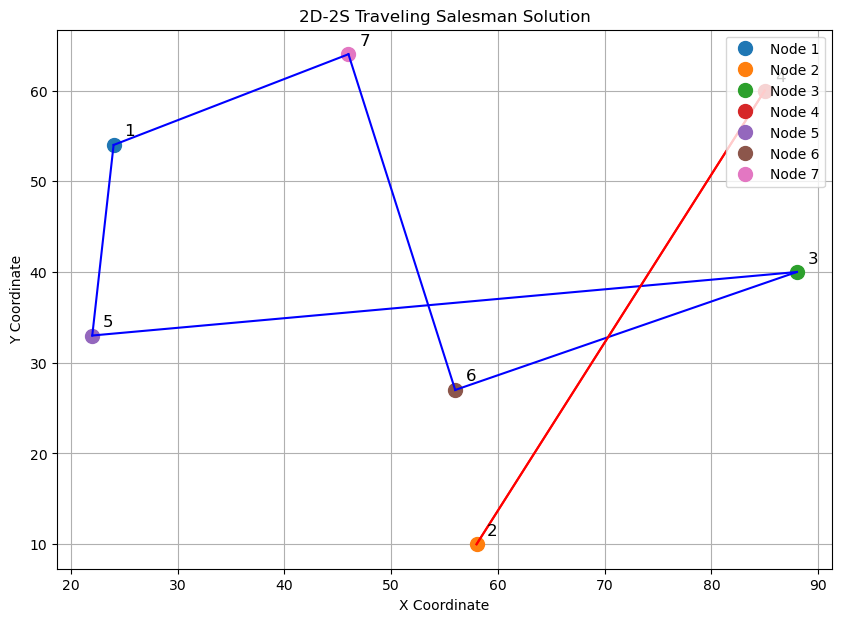

In [173]:
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt

# Cost matrix
cost = [
    [0, 786, 549, 657, 331, 559, 250],
    [786, 0, 668, 979, 593, 224, 905],
    [549, 668, 0, 316, 607, 472, 467],
    [657, 979, 316, 0, 890, 769, 400],
    [331, 593, 607, 890, 0, 386, 559],
    [559, 224, 472, 769, 386, 0, 681],
    [250, 905, 467, 400, 559, 681, 0]
]

# Swap rows and columns 1 and 2 for the updated cost matrix
cost[1], cost[2] = cost[2], cost[1]
for row in cost:
    row[1], row[2] = row[2], row[1]

# Node positions for plotting
positions = [[24, 54], [58, 10], [88, 40], [85, 60], [22, 33], [56, 27], [46, 64]]
n = len(cost)

# Create a new model
model = gp.Model("2D-2S_mTSP")

# Binary variables for each edge and salesman
x = model.addVars(n, n, 2, vtype=GRB.BINARY, name="x")

# Position variables for subtour elimination (Miller-Tucker-Zemlin)
u = model.addVars(n, 2, vtype=GRB.CONTINUOUS, name="u")

# Objective: minimize the total travel cost across both salesmen's tours
model.setObjective(gp.quicksum(cost[i][j] * x[i, j, k] for i in range(n) for j in range(n) for k in range(2)), GRB.MINIMIZE)

# Constraints
# Each salesman starts from their assigned depot
model.addConstr(gp.quicksum(x[0, j, 0] for j in range(1, n)) == 1, "depot_start_salesman_1")
model.addConstr(gp.quicksum(x[1, j, 1] for j in range(2, n)) == 1, "depot_start_salesman_2")

# Each salesman returns to their assigned depot
model.addConstr(gp.quicksum(x[j, 0, 0] for j in range(1, n)) == 1, "depot_return_salesman_1")
model.addConstr(gp.quicksum(x[j, 1, 1] for j in range(2, n)) == 1, "depot_return_salesman_2")

# Each city is visited exactly once by one salesman
for j in range(2, n):
    model.addConstr(gp.quicksum(x[i, j, k] for i in range(n) for k in range(2) if i != j) == 1, f"visit_{j}")

# Continuity constraints: each city has one entry and one exit per salesman
for k in range(2):
    for i in range(2, n):
        model.addConstr(gp.quicksum(x[i, j, k] for j in range(n) if j != i) == gp.quicksum(x[j, i, k] for j in range(n) if j != i), f"continuity_{i}_{k}")

# Subtour elimination constraints (Miller-Tucker-Zemlin)
for k in range(2):
    for i in range(2, n):
        for j in range(2, n):
            if i != j:
                model.addConstr(u[i, k] - u[j, k] + n * x[i, j, k] <= n - 1, f"subtour_{i}_{j}_{k}")

# Optimize the model
model.optimize()

# Display results and plot if an optimal solution is found
if model.status == GRB.OPTIMAL:
    print("Optimal solution found with cost:", model.objVal)
    for k in range(2):
        print(f"\nSalesman {k + 1} route:")
        for i in range(n):
            for j in range(n):
                if x[i, j, k].x > 0.5:
                    print(f" {i + 1} -> {j + 1} with cost {cost[i][j]}")
                    
    # Plotting the solution
    plt.figure(figsize=(10, 7))
    plt.title("2D-2S Traveling Salesman Solution")
    
    # Plot nodes
    for i, pos in enumerate(positions):
        plt.plot(pos[0], pos[1], 'o', markersize=10, label=f"Node {i+1}")
        plt.text(pos[0]+1, pos[1]+1, f"{i+1}", fontsize=12)
    
    # Plot routes for each salesman
    colors = ['b', 'r']  # Different colors for each salesman
    for k in range(2):
        for i in range(n):
            for j in range(n):
                if x[i, j, k].x > 0.5:
                    start, end = positions[i], positions[j]
                    plt.plot([start[0], end[0]], [start[1], end[1]], colors[k], linestyle='-', linewidth=1.5, label=f"Salesman {k+1}" if i == 0 and j == 1 else "")
    
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()
else:
    print("No optimal solution found.")

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 23.6.0 23G93)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 59 rows, 112 columns and 322 nonzeros
Model fingerprint: 0x998d491a
Variable types: 14 continuous, 98 integer (98 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+00]
  Objective range  [2e+02, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Found heuristic solution: objective 5218.0000000
Presolve removed 0 rows and 22 columns
Presolve time: 0.00s
Presolved: 59 rows, 90 columns, 320 nonzeros
Variable types: 10 continuous, 80 integer (80 binary)
Found heuristic solution: objective 4802.0000000

Root relaxation: objective 2.220000e+03, 20 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2220

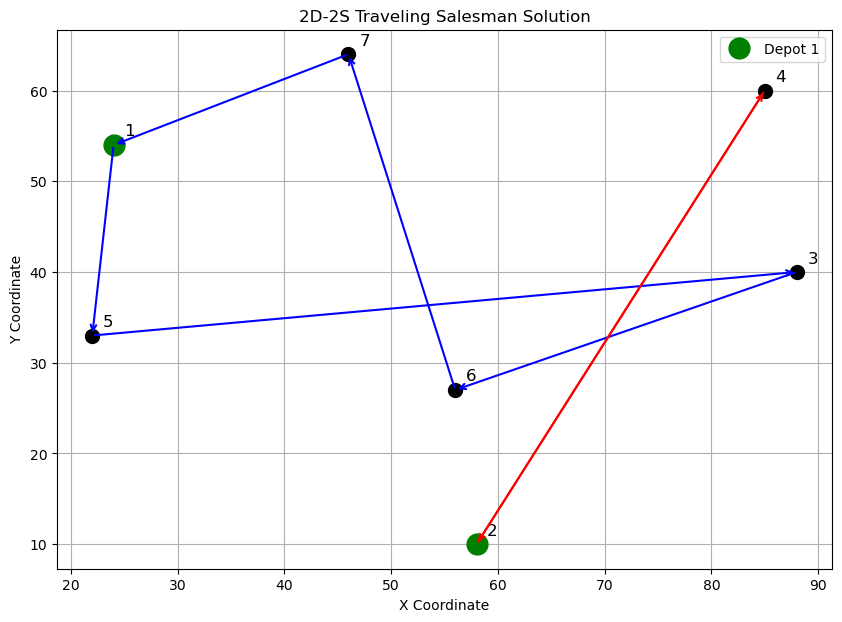

In [175]:
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt

# Cost matrix
cost = [
    [0, 786, 549, 657, 331, 559, 250],
    [786, 0, 668, 979, 593, 224, 905],
    [549, 668, 0, 316, 607, 472, 467],
    [657, 979, 316, 0, 890, 769, 400],
    [331, 593, 607, 890, 0, 386, 559],
    [559, 224, 472, 769, 386, 0, 681],
    [250, 905, 467, 400, 559, 681, 0]
]

# Swap rows and columns 1 and 2 for the updated cost matrix
cost[1], cost[2] = cost[2], cost[1]
for row in cost:
    row[1], row[2] = row[2], row[1]

# Node positions for plotting
positions = [[24, 54], [58, 10], [88, 40], [85, 60], [22, 33], [56, 27], [46, 64]]
n = len(cost)

# Create a new model
model = gp.Model("2D-2S_mTSP")

# Binary variables for each edge and salesman
x = model.addVars(n, n, 2, vtype=GRB.BINARY, name="x")

# Position variables for subtour elimination (Miller-Tucker-Zemlin)
u = model.addVars(n, 2, vtype=GRB.CONTINUOUS, name="u")

# Objective: minimize the total travel cost across both salesmen's tours
model.setObjective(gp.quicksum(cost[i][j] * x[i, j, k] for i in range(n) for j in range(n) for k in range(2)), GRB.MINIMIZE)

# Constraints
# Each salesman starts from their assigned depot
model.addConstr(gp.quicksum(x[0, j, 0] for j in range(1, n)) == 1, "depot_start_salesman_1")
model.addConstr(gp.quicksum(x[1, j, 1] for j in range(2, n)) == 1, "depot_start_salesman_2")

# Each salesman returns to their assigned depot
model.addConstr(gp.quicksum(x[j, 0, 0] for j in range(1, n)) == 1, "depot_return_salesman_1")
model.addConstr(gp.quicksum(x[j, 1, 1] for j in range(2, n)) == 1, "depot_return_salesman_2")

# Each city is visited exactly once by one salesman
for j in range(2, n):
    model.addConstr(gp.quicksum(x[i, j, k] for i in range(n) for k in range(2) if i != j) == 1, f"visit_{j}")

# Continuity constraints: each city has one entry and one exit per salesman
for k in range(2):
    for i in range(2, n):
        model.addConstr(gp.quicksum(x[i, j, k] for j in range(n) if j != i) == gp.quicksum(x[j, i, k] for j in range(n) if j != i), f"continuity_{i}_{k}")

# Subtour elimination constraints (Miller-Tucker-Zemlin)
for k in range(2):
    for i in range(2, n):
        for j in range(2, n):
            if i != j:
                model.addConstr(u[i, k] - u[j, k] + n * x[i, j, k] <= n - 1, f"subtour_{i}_{j}_{k}")

# Optimize the model
model.optimize()

# Display results and plot if an optimal solution is found
if model.status == GRB.OPTIMAL:
    print("Optimal solution found with cost:", model.objVal)
    for k in range(2):
        print(f"\nSalesman {k + 1} route:")
        for i in range(n):
            for j in range(n):
                if x[i, j, k].x > 0.5:
                    print(f" {i + 1} -> {j + 1} with cost {cost[i][j]}")
                    
    # Plotting the solution
    plt.figure(figsize=(10, 7))
    plt.title("2D-2S Traveling Salesman Solution")

    # Define colors for the salesmen and larger markers for depots
    colors = ['blue', 'red']  # Different colors for each salesman
    depot_nodes = [0, 1]  # Node 1 and Node 2 as depots
    
    # Plot all nodes
    for i, pos in enumerate(positions):
        if i in depot_nodes:
            plt.plot(pos[0], pos[1], 'o', markersize=15, color='green', label=f"Depot {i + 1}" if i == 0 else "")
        else:
            plt.plot(pos[0], pos[1], 'o', markersize=10, color='black')
        plt.text(pos[0] + 1, pos[1] + 1, f"{i + 1}", fontsize=12)

    # Plot routes with arrows for each salesman
    for k in range(2):
        for i in range(n):
            for j in range(n):
                if x[i, j, k].x > 0.5:
                    start, end = positions[i], positions[j]
                    plt.annotate(
                        "", xy=(end[0], end[1]), xytext=(start[0], start[1]),
                        arrowprops=dict(arrowstyle="->", color=colors[k], lw=1.5),
                        label=f"Salesman {k+1}" if (i, j) == (depot_nodes[k], depot_nodes[1-k]) else ""
                    )

    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()
else:
    print("No optimal solution found.")